In [2]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/PPS/lib/python3.10/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


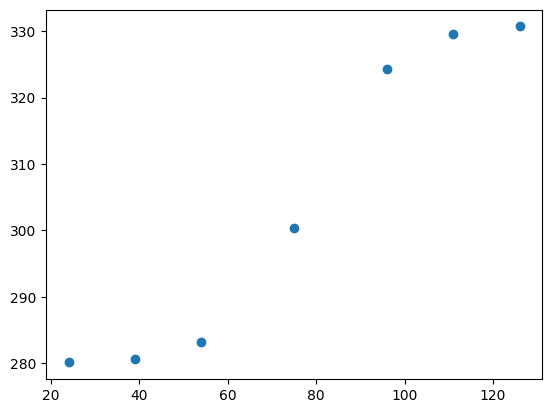

In [12]:
a_distances = np.array([24, 39, 54, 75, 96, 111, 126])

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 120 - 1.377 * 30
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(a_distances, fprHCCP, fprHCS)
plt.scatter(a_distances, HC_RTs)

In [13]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.275, 2, 1.275, 2, 1.275, 2)


def boundaryhcmodelrun(theta):
    HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
        6.5, 6.5, 6.5, 6.55, 6.55, 6.55, theta[0], theta[1], theta[2], theta[3]
    )  # feedforward and feedback
    _, _, _, _, HCrt = experiment(
        0.4,
        200,
        a_distances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrt
    yf = HC_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(1, 50), (500, 1000), (20, 80), (0.25, 1)]  # k1, k2, lim, alpha
boundaryhcres = differential_evolution(
    boundaryhcmodelrun, bounds, disp=True, workers=-1, updating="deferred"
)

KeyboardInterrupt: 